In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ccaModels import CCA_MarkovChain_CUBIC_OG, CCA_MarkovChain_Hybla_discrete, CCA_MarkovChain_Hybla, CCA_MarkovChain_CUBIC_new

#plt.rcParams['text.usetex'] = True
plt.rcParams.update(plt.rcParamsDefault)

In [2]:
hyb = CCA_MarkovChain_Hybla_discrete(packet_err=0.0006,beta=0.5,N=100,C =1000, RTT_est=0.2, RTT_real = 0.5, RTT0=0.1)
cub = CCA_MarkovChain_CUBIC_new(packet_err = 0.0006, beta=0.5,N=100,C =1000, RTT_est=0.2, RTT_real = 0.5)

a = 10
b = 20
print(hyb.D(hyb.a[int(a/2)],hyb.a[b]), cub.D(cub.a[a],cub.a[b]))

1181 716


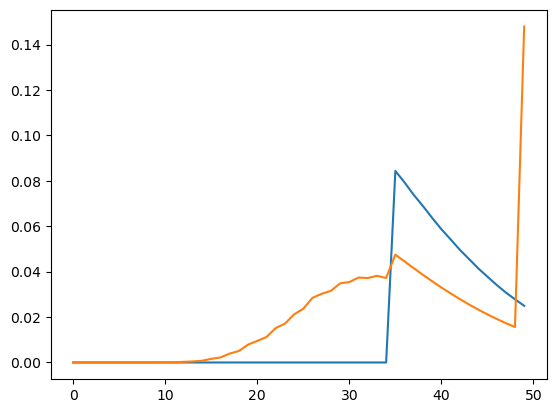

0.752223005236446
[[0.03 0.23 0.43 ... 9.43 9.63 9.83]
 [0.   0.09 0.29 ... 9.29 9.49 9.69]
 [0.   0.   0.15 ... 9.15 9.35 9.55]
 ...
 [0.   0.   0.   ... 2.85 3.05 3.25]
 [0.   0.   0.   ... 2.71 2.91 3.11]
 [0.   0.   0.   ... 2.57 2.77 2.97]]


In [5]:
hyb = CCA_MarkovChain_Hybla_discrete(packet_err=0.0006,beta=0.7,N=50,C =1000, RTT_est=0.2, RTT_real = 0.21, RTT0=0.1)

#for b in np.arange(2,20,2):
#    print(hyb.D(hyb.a[1], (b-1)*hyb.W/hyb.N))
#    print(hyb.D(hyb.a[1], hyb.a[b]))
#    print(hyb.D(hyb.a[1], b*hyb.W/hyb.N))
#    print("----")
tp = np.zeros(hyb.N)
for j,_ in enumerate(tp):
    tp[j] = hyb.transition_proba_Hybla(49,j)
plt.plot(tp)
hyb.compute_stationnary_distribution()
plt.plot(hyb.pi)
plt.show()
print(hyb.avg_throughput())
print(hyb.tau)

In [19]:
print(hyb.a[1],hyb.a[4])
print(hyb.a[2]-0.5*hyb.a[5])
print(hyb.T(hyb.a[1],hyb.a[5]))
#self.RTT0**2*(y-self.beta*x)/self.RTT_real
(5-0.5)*hyb.W/hyb.N

15.75 47.25
-2.625
0.05250000000000008


47.25

3.621964664966512
6.020404329078785


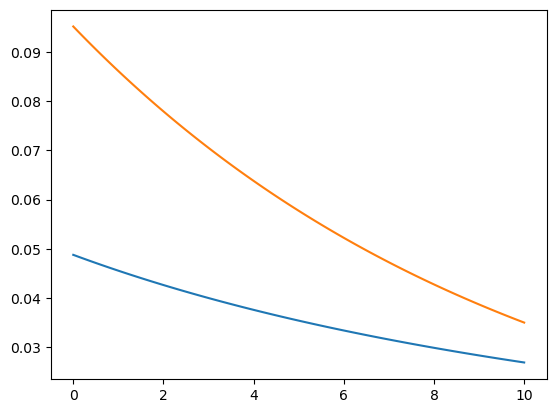

In [23]:
t = np.linspace(0,10,100)
w0 = 100
rtt = 0.5
l = 1/10
e = 0.1
w = w0+t/rtt # cwnd in MSS
b = w/rtt # MSS/s

p = np.exp(-t/(e*b))-np.exp(-(t+1)/(e*b))
pold = np.exp(-l*t)-np.exp(-l*(t+1))

plt.plot(t,p)
plt.plot(t,pold)
print(np.sum(np.exp(-t/(e*b))-np.exp(-(t+1)/(e*b))))
print(np.sum(np.exp(-l*t)-np.exp(-l*(t+1))))

In [1]:
def P(t, eps):
    return (1-eps)**(t-1)*eps

P(1,0.1)+P(2,0.1)

0.19

In [6]:
sum = 0
for i in [1,2,3,4]:
    sum+= P(i,0.1)

print(sum)

0.34390000000000004


In [10]:
import numpy as np
import scipy

P = [[0.19,0.15,0.66],[0.271,0.1385,0.599],[0,0.344,0.656]]

ws,vs = scipy.sparse.linalg.eigs(A=np.transpose(P),k=1,sigma=1)
pi = np.real(vs/vs.sum())[:,0]

print(pi)
print(np.sum(pi))

[0.09018778 0.27032966 0.63948256]
1.0


In [2]:
1/np.arange(10)

/tmp/ipykernel_25408/4242892561.py:1: RuntimeWarning: divide by zero encountered in divide
  1/np.arange(10)


array([       inf, 1.        , 0.5       , 0.33333333, 0.25      ,
       0.2       , 0.16666667, 0.14285714, 0.125     , 0.11111111])

In [8]:
def wc(t):
    return (t-np.cbrt(100*0.3))**3+100

def w_next(w,rtt,t):
    return w+(wc(t+rtt)-w)/w

In [15]:
rtt = 0.1
c = 70
for i in range(70):
    c = w_next(c,rtt,rtt+i*rtt)
    if i%10==0:
        print(c)
print(c)
print(wc(rtt))

70.07754383438456
72.24928012790619
75.43804769716698
78.43866153992114
81.05014108817197
83.7968869647492
87.73479597878843
93.42292949741868
72.80425117863827
